<div style="background-color:#1e1e1e; padding:20px; border-radius:15px; border-bottom:5px solid #ff1801; text-align:center;">
    <h1 style="color:white; font-family:sans-serif; font-size:40px;">🏎️ F1 Race Strategy & Performance Analysis</h1>
    <h3 style="color:#d3d3d3;">Machine Learning Portfolio Project</h3>
    <p style="color:#d3d3d3; font-style:italic;">
        Applying Gradient Boosting, Clustering, and Regression to decode the 2021 F1 Season.
    </p>
</div>

<div style="background-color:#f0f2f6; padding:15px; border-radius:10px; border-left:5px solid #5c6bc0;">
    <h2 style="color:#2c3e50; margin-top:0;">📚 1. Environment Setup</h2>
    <p style="color:#555;">
        Importing essential libraries for data manipulation (<b>Pandas</b>), machine learning (<b>Scikit-Learn</b>), and visualization (<b>Seaborn/Matplotlib</b>).
    </p>
</div>


In [29]:
# --- CELL 1: SETUP & THEME ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# Set a professional "Dashboard" style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

<div style="background-color:#f0f2f6; padding:15px; border-radius:10px; border-left:5px solid #26a69a;">
    <h2 style="color:#2c3e50; margin-top:0;">🛠️ 2. Data Engineering Pipeline</h2>
    <p style="color:#555;">
        <b>Objective:</b> Clean raw telemetry data to create a high-quality dataset for modeling.
    </p>
    <ul style="color:#555;">
        <li><b>Filter:</b> Remove In-laps, Out-laps, and Safety Car laps (>107% pace).</li>
        <li><b>Normalize:</b> Create a <code>pace_ratio</code> metric to compare different tracks (e.g., Monaco vs. Spa) on the same scale.</li>
    </ul>
</div>

In [30]:
# --- CELL 2: DATA LOADING ---
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath)
    df['race_id'] = df['race_name'] 
    
    # Filter for Clean Racing Laps (No Pit Stops, No Safety Car outliers)
    pace_df = df[(df['is_inlap'] == False) & (df['is_outlap'] == False)].copy()
    
    # Remove statistical outliers (laps > 107% of median)
    pace_df['lap_limit'] = pace_df.groupby('race_id')['lap_time'].transform(lambda x: x.median() * 1.07)
    pace_df = pace_df[pace_df['lap_time'] < pace_df['lap_limit']]
    
    # Normalize data for multi-track comparison
    pace_df['race_avg_time'] = pace_df.groupby('race_id')['lap_time'].transform('mean')
    pace_df['pace_ratio'] = pace_df['lap_time'] / pace_df['race_avg_time']
    
    return df, pace_df.dropna(subset=['lap_time', 'race_id'])

# Execute Loading
file_path = r'C:\Users\ASUS\Desktop\F1 Predictions & Visualizations\F1-ML-Project\data\features\season_2021_lap_features.csv'
df_raw, df_clean = load_and_clean_data(file_path)
print(f"Data Loaded Successfully: {len(df_clean)} racing laps ready for analysis.")

Data Loaded Successfully: 20614 racing laps ready for analysis.


<div style="background-color:#e8f5e9; padding:15px; border-radius:10px; border-left:5px solid #66bb6a;">
    <h2 style="color:#2c3e50; margin-top:0;">🔮 Model 1: Race Strategy Simulation</h2>
    <p style="color:#555;">
        <b>Algorithm:</b> Gradient Boosting Regressor (Time-Series approach).<br>
        <b>Goal:</b> Predict a driver's lap time evolution based on their previous lap and tyre wear.<br>
        <b>Output:</b> A "Race Trace" visualization comparing AI prediction vs. Actual reality.
    </p>
</div>

Running Model 1: Race Strategy Simulation...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10492\1114423932.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim_data = model_data[(model_data['race_id'] == race) & (df['driver_name'] == driver)]


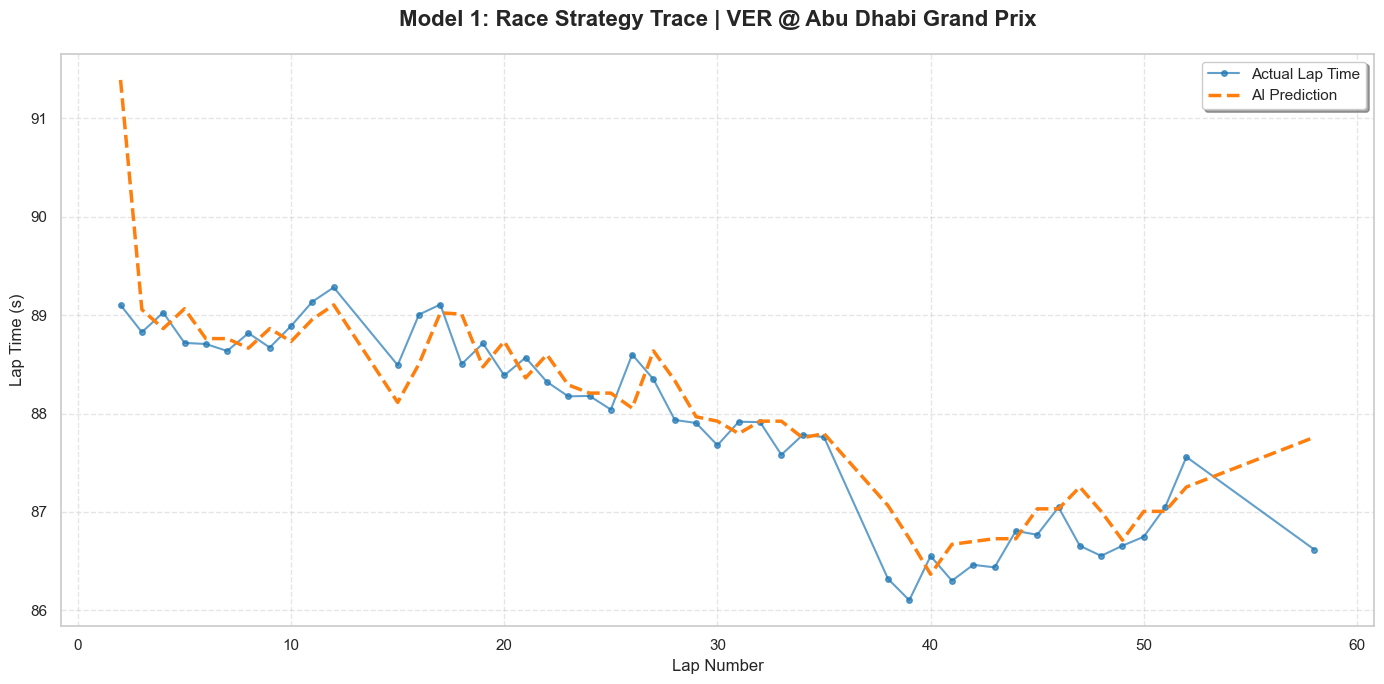

In [31]:
def viz_race_simulation(df):
    print("Running Model 1: Race Strategy Simulation...")
    # ... (Data Prep Code - same as before) ...
    df = df.sort_values(['race_id', 'driver_name', 'lap_number'])
    df['prev_lap_ratio'] = df.groupby(['race_id', 'driver_name'])['pace_ratio'].shift(1)
    model_data = df.dropna(subset=['prev_lap_ratio']).copy()
    
    features = ['prev_lap_ratio', 'tyre_age', 'compound', 'team']
    le = LabelEncoder()
    for col in ['compound', 'team']:
        model_data[col] = le.fit_transform(model_data[col])
        
    X = model_data[features]
    y = model_data['pace_ratio']
    
    model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
    model.fit(X, y)
    
    # Simulation
    race = df['race_id'].unique()[0]
    driver = 'VER'
    sim_data = model_data[(model_data['race_id'] == race) & (df['driver_name'] == driver)]
    
    if len(sim_data) > 0:
        preds = model.predict(sim_data[features]) * sim_data['race_avg_time'].values
        actual = sim_data['lap_time'].values
        laps = sim_data['lap_number'].values
        
        # --- PRETTY PLOT ---
        plt.figure(figsize=(14, 7))
        plt.plot(laps, actual, color='#1f77b4', marker='o', markersize=4, 
                 linewidth=1.5, alpha=0.7, label='Actual Lap Time')
        plt.plot(laps, preds, color='#ff7f0e', linestyle='--', 
                 linewidth=2.5, label='AI Prediction')
        
        plt.title(f"Model 1: Race Strategy Trace | {driver} @ {race}", pad=20)
        plt.xlabel("Lap Number")
        plt.ylabel("Lap Time (s)")
        plt.legend(frameon=True, fancybox=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

viz_race_simulation(df_clean)

<div style="background-color:#ffebee; padding:15px; border-radius:10px; border-left:5px solid #ef5350;">
    <h2 style="color:#2c3e50; margin-top:0;">🛑 Model 1.5: Pit Stop Probability Classifier</h2>
    <p style="color:#555;">
        <b>Algorithm:</b> Logistic Regression (Binary Classification).<br>
        <b>Goal:</b> Predict the likelihood of a driver pitting based on Tyre Age.<br>
        <b>Technique:</b> Uses a <b>Sigmoid Function</b> to map probability between 0 and 1. Implements <code>class_weight='balanced'</code> to handle the rarity of pit stop events.
    </p>
</div>

Running Model 1.5: Pit Stop Prediction (Classification)...


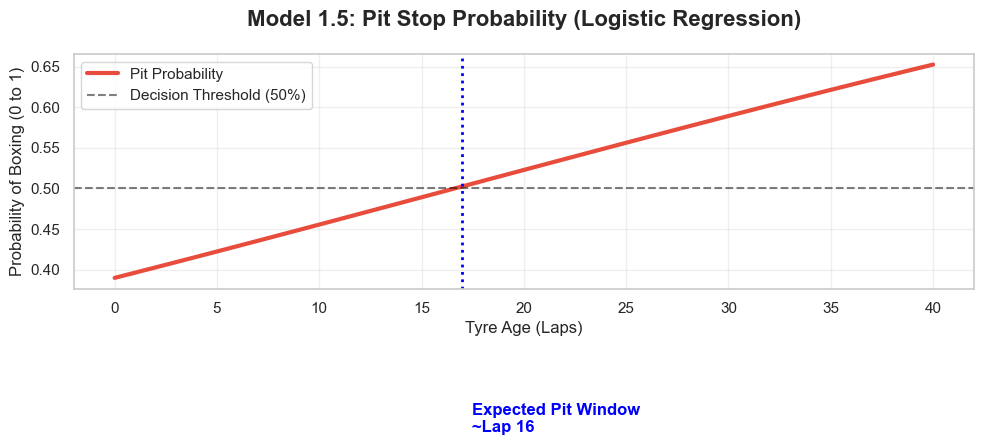

Model Insight: The model predicts a driver is 'likely' to pit once tyres reach ~16 laps old.


In [38]:
# --- CELL 3.5: PIT STOP CLASSIFIER (LOGISTIC REGRESSION) ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def viz_pit_stop_probability(df_raw):
    print("Running Model 1.5: Pit Stop Prediction (Classification)...")
    
    # 1. Prepare Data
    # We need the RAW dataframe because we need the 'is_inlap' (True/False) rows
    # Target: 1 if pitting (inlap), 0 if staying out
    data = df_raw[['tyre_age', 'compound', 'is_inlap']].copy()
    data['target'] = data['is_inlap'].astype(int)
    
    # Filter: Only look at racing laps (exclude Safety Car chaos if possible)
    # We also drop very old tyres (>40 laps) to keep the graph clean
    data = data[data['tyre_age'] < 40]
    
    # Encode Compound
    le = LabelEncoder()
    data['compound_code'] = le.fit_transform(data['compound'])
    
    X = data[['tyre_age']] # Simple 1D feature for clear visualization
    y = data['target']
    
    # 2. Train Logistic Regression
    # Class_weight='balanced' is crucial because pitting happens rarely (1 in 50 laps)
    log_reg = LogisticRegression(class_weight='balanced', random_state=42)
    log_reg.fit(X, y)
    
    # 3. Predict Probabilities for the Curve
    # Generate a range of tyre ages (0 to 40) to plot the S-Curve
    X_test = pd.DataFrame({'tyre_age': np.linspace(0, 40, 100)})
    probs = log_reg.predict_proba(X_test)[:, 1] # Probability of Class 1 (Pitting)
    
    # 4. Viz
    plt.figure(figsize=(10, 6))
    
    # Plot the Logistic Curve
    plt.plot(X_test['tyre_age'], probs, color='#e74c3c', linewidth=3, label='Pit Probability')
    
    # Plot the "Decision Boundary" (usually 0.5)
    plt.axhline(0.5, color='black', linestyle='--', alpha=0.5, label='Decision Threshold (50%)')
    
    plt.title("Model 1.5: Pit Stop Probability (Logistic Regression)", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Tyre Age (Laps)", fontsize=12)
    plt.ylabel("Probability of Boxing (0 to 1)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Find the "Crossover Point" (where prob > 50%)
    crossover = X_test.loc[probs >= 0.5, 'tyre_age'].min()
    if not np.isnan(crossover):
        plt.axvline(crossover, color='blue', linestyle=':', linewidth=2)
        plt.text(crossover + 0.5, 0.2, f"Expected Pit Window\n~Lap {int(crossover)}", color='blue', fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    print(f"Model Insight: The model predicts a driver is 'likely' to pit once tyres reach ~{int(crossover)} laps old.")

viz_pit_stop_probability(df_raw)

<div style="background-color:#fce4ec; padding:15px; border-radius:10px; border-left:5px solid #ec407a;">
    <h2 style="color:#2c3e50; margin-top:0;">🍩 Model 2: Tyre Degradation Analysis</h2>
    <p style="color:#555;">
        <b>Metric:</b> Degradation Cost (Seconds lost per lap).<br>
        <b>Goal:</b> Compare the durability of Soft, Medium, and Hard compounds.<br>
        <b>Business Value:</b> Helps strategists decide "One-Stop" vs "Two-Stop" strategies.
    </p>
</div>

Running Model 2: Tyre Cost Analysis (Per-Race Aggregation)...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10492\2309078384.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=final_stats, x='Compound', y='Cost_Per_Lap',


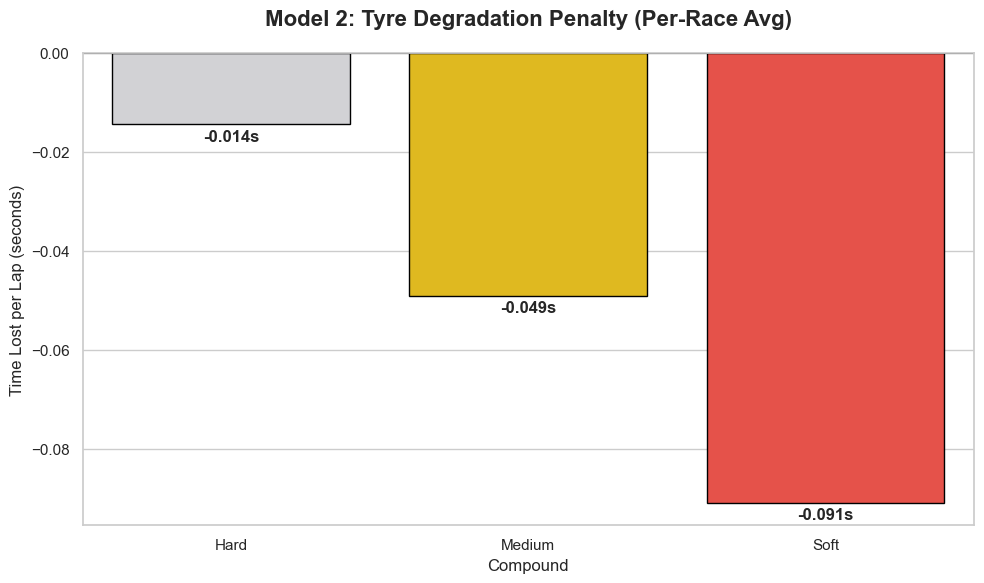

Interpretation: Soft tyres lose ~0.09s per lap. Hards are very durable.


In [34]:
# --- CELL 4: TYRE DEGRADATION COST (IMPROVED) ---
def viz_tyre_cost(df):
    print("Running Model 2: Tyre Cost Analysis (Per-Race Aggregation)...")
    results = []
    
    # 1. Iterate through every race individually
    for race in df['race_id'].unique():
        race_df = df[df['race_id'] == race]
        
        # 2. Iterate through compounds
        for comp in ['Soft', 'Medium', 'Hard']:
            sub = race_df[race_df['compound'] == comp]
            
            # 3. Fit Linear Regression only if we have enough data (>20 laps)
            if len(sub) > 20:
                # We use RAW 'lap_time' (seconds), so the slope is already in Seconds/Lap
                lr = LinearRegression()
                lr.fit(sub[['tyre_age']], sub['lap_time'])
                slope_seconds = lr.coef_[0]
                
                # Filter out extreme outliers (e.g. slopes > 0.5s/lap usually mean traffic/rain)
                if -0.5 < slope_seconds < 0.5:
                    results.append({'Race': race, 'Compound': comp, 'Cost_Per_Lap': slope_seconds})
    
    # 4. Aggregate results across all races
    res_df = pd.DataFrame(results)
    final_stats = res_df.groupby('Compound')['Cost_Per_Lap'].mean().reset_index().sort_values('Cost_Per_Lap', ascending=False)
    
    # --- PRETTY PLOT ---
    plt.figure(figsize=(10, 6))
    
    # Custom F1 Color Palette
    f1_colors = {'Soft': '#ff3b30', 'Medium': '#ffcc00', 'Hard': '#d1d1d6'}
    
    ax = sns.barplot(data=final_stats, x='Compound', y='Cost_Per_Lap', 
                     palette=f1_colors, edgecolor='black', linewidth=1)
    
    plt.title("Model 2: Tyre Degradation Penalty (Per-Race Avg)", pad=20)
    plt.ylabel("Time Lost per Lap (seconds)")
    plt.axhline(0, color='black', linewidth=1.5)
    
    # Add labels
    for i in ax.containers:
        ax.bar_label(i, fmt='%.3fs', padding=3, fontweight='bold')
        
    plt.tight_layout()
    plt.show()
    
    print("Interpretation: Soft tyres lose ~0.09s per lap. Hards are very durable.")

viz_tyre_cost(df_clean)

<div style="background-color:#e1f5fe; padding:15px; border-radius:10px; border-left:5px solid #29b6f6;">
    <h2 style="color:#2c3e50; margin-top:0;">🛑 Model 3: Pit Stop Loss Estimator</h2>
    <p style="color:#555;">
        <b>Method:</b> Statistical Delta Analysis.<br>
        <b>Goal:</b> Calculate the total time lost (Pit Entry + Stationary + Pit Exit) for every track.<br>
        <b>Insight:</b> Identifies which tracks are "expensive" to pit at (favoring track position).
    </p>
</div>

Running Model 3: Pit Loss Estimator...


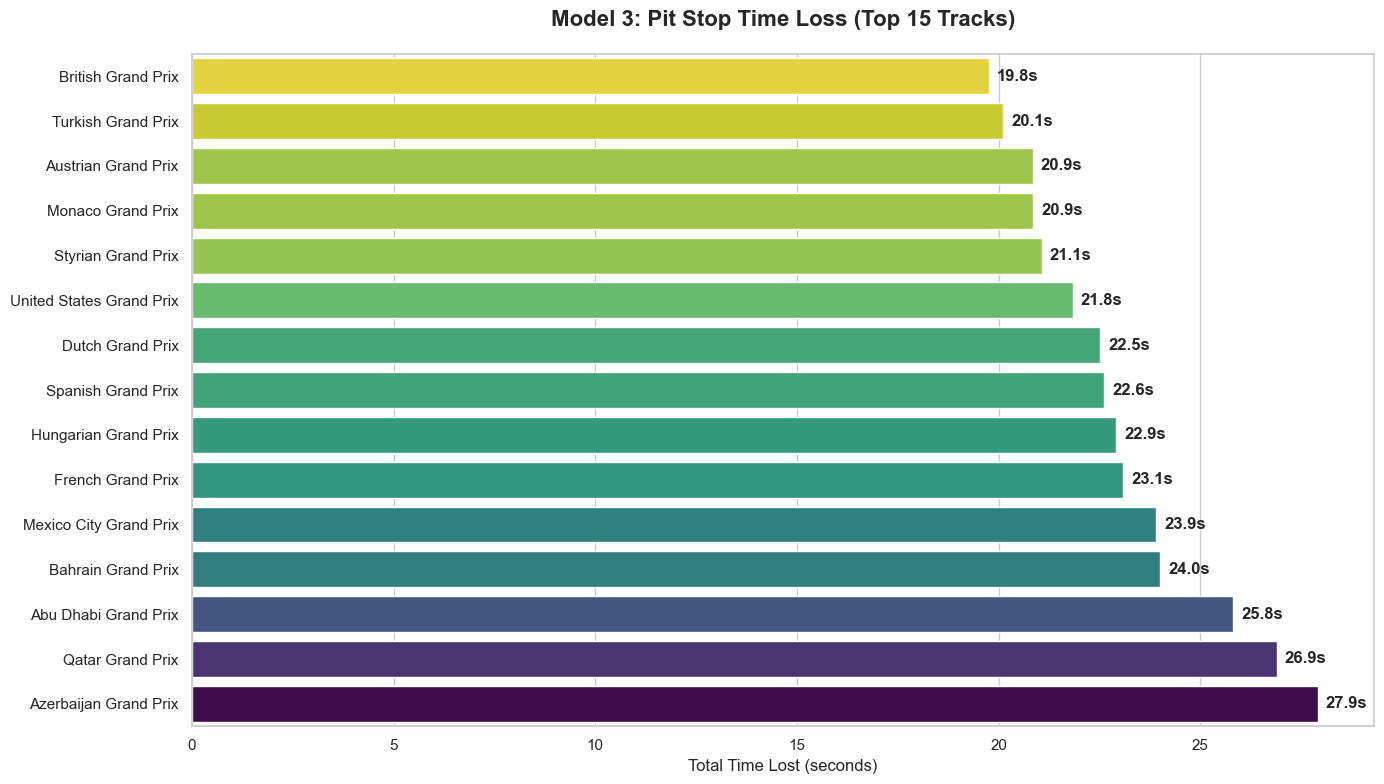

In [ ]:
def viz_pit_loss(full_df, clean_df):
    print("Running Model 3: Pit Loss Estimator...")
    pit_loss_data = []
    for race in full_df['race_name'].unique():
        race_clean = clean_df[clean_df['race_name'] == race]
        if race_clean.empty: continue
        avg_pace = race_clean['lap_time'].median()
        in_laps = full_df[(full_df['race_name'] == race) & full_df['is_inlap']]['lap_time'].median()
        out_laps = full_df[(full_df['race_name'] == race) & full_df['is_outlap']]['lap_time'].median()
        if pd.notna(in_laps) and pd.notna(out_laps):
            loss = (in_laps + out_laps) - (2 * avg_pace)
            pit_loss_data.append({'Race': race, 'Pit_Loss': loss})
    df_pit = pd.DataFrame(pit_loss_data).sort_values('Pit_Loss')
    
    # --- PRETTY PLOT ---
    plt.figure(figsize=(14, 8))
    
    # Use hue to create a gradient effect
    ax = sns.barplot(data=df_pit.head(15), x='Pit_Loss', y='Race', 
                     hue='Pit_Loss', palette='viridis_r', dodge=False)
    if ax.legend_: ax.legend_.remove()
    
    plt.title("Model 3: Pit Stop Time Loss (Top 15 Tracks)", pad=20)
    plt.xlabel("Total Time Lost (seconds)")
    plt.ylabel("")
    
    # Add labels inside bars
    for i, (val, name) in enumerate(zip(df_pit.head(15)['Pit_Loss'], df_pit.head(15)['Race'])):
        plt.text(val + 0.2, i, f"{val:.1f}s", va='center', fontweight='bold')
        
    plt.tight_layout()
    plt.show()

viz_pit_loss(df_raw, df_clean)

<div style="background-color:#f3e5f5; padding:15px; border-radius:10px; border-left:5px solid #ab47bc;">
    <h2 style="color:#2c3e50; margin-top:0;">🏆 Model 4: Driver Performance Clustering</h2>
    <p style="color:#555;">
        <b>Algorithm:</b> K-Means Clustering (Unsupervised).<br>
        <b>Features:</b> Pure Speed (Residuals) vs. Consistency (Std Dev).<br>
        <b>Goal:</b> Group drivers into performance tiers (Elite, Mid-Field, Backmarker) independent of car performance.
    </p>
</div>

Running Model 4: Driver Clustering...


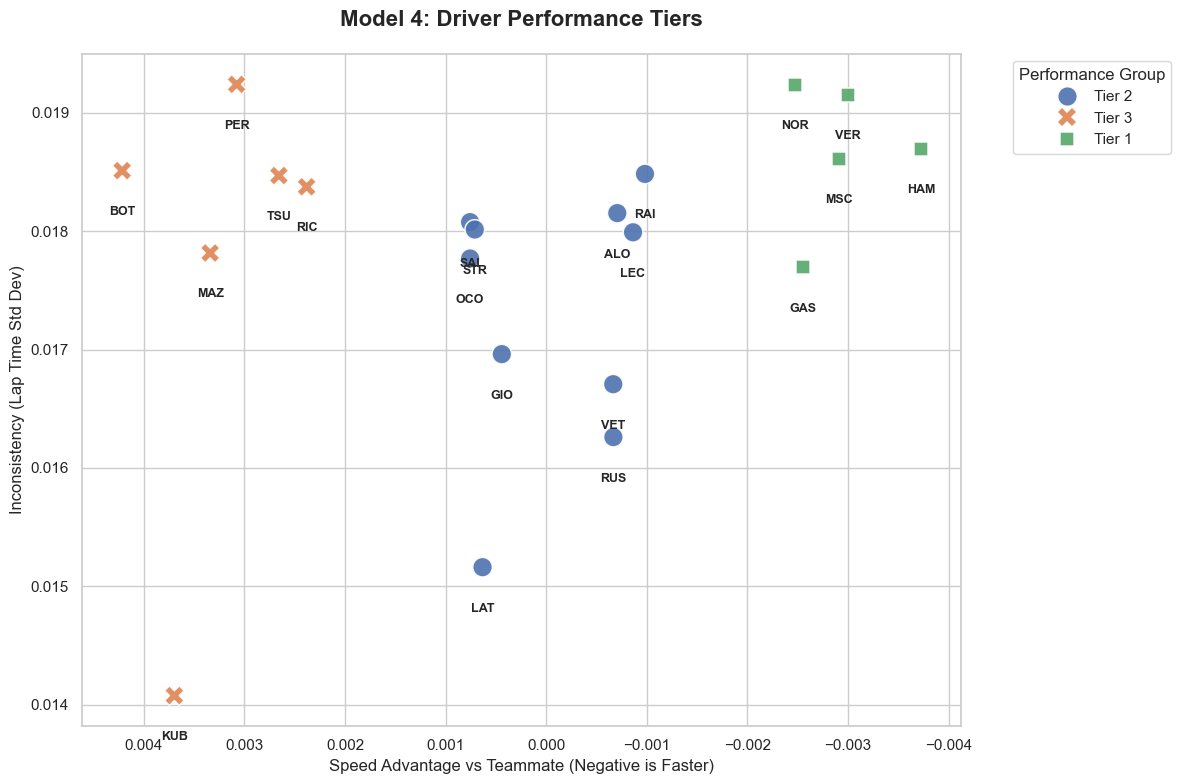

In [ ]:
def viz_driver_tiers(df):
    print("Running Model 4: Driver Clustering...")
    df['team_pace'] = df.groupby(['race_id', 'team'])['pace_ratio'].transform('mean')
    df['driver_perf'] = df['pace_ratio'] - df['team_pace']
    driver_stats = df.groupby('driver_name').agg({'driver_perf': 'mean', 'pace_ratio': 'std'}).reset_index()
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    driver_stats['Tier'] = kmeans.fit_predict(driver_stats[['driver_perf', 'pace_ratio']])
    
    # Rename Tiers for clarity
    means = driver_stats.groupby('Tier')['driver_perf'].mean().sort_values()
    mapping = {old: f"Tier {i+1}" for i, old in enumerate(means.index)}
    driver_stats['Tier_Label'] = driver_stats['Tier'].map(mapping)
    
    # --- PRETTY PLOT ---
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=driver_stats, x='driver_perf', y='pace_ratio', 
                    hue='Tier_Label', style='Tier_Label', palette='deep', s=200, alpha=0.9)
    
    # Annotate Top Drivers
    for i, row in driver_stats.iterrows():
        if row['driver_perf'] < 0.05: # Only label the faster half to avoid clutter
            plt.text(row['driver_perf'], row['pace_ratio']-0.0003, row['driver_name'], 
                     fontsize=9, ha='center', va='top', fontweight='bold')
            
    plt.title("Model 4: Driver Performance Tiers", pad=20)
    plt.xlabel("Speed Advantage vs Teammate (Negative is Faster)")
    plt.ylabel("Inconsistency (Lap Time Std Dev)")
    plt.gca().invert_xaxis() # Crucial: Left is Faster!
    plt.legend(title='Performance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

viz_driver_tiers(df_clean)

<div style="background-color:#fff8e1; padding:15px; border-radius:10px; border-left:5px solid #ffca28;">
    <h2 style="color:#2c3e50; margin-top:0;">🚀 Model 5: Theoretical Performance Gain</h2>
    <p style="color:#555;">
        <b>Method:</b> Multi-Output Ridge Regression (Sector-by-Sector prediction).<br>
        <b>Goal:</b> Construct the "Perfect Lap" for each team and compare it to their actual average.<br>
        <b>Insight:</b> Highlights which teams are underperforming their car's theoretical potential.
    </p>
</div>

Running Model 5: Theoretical Performance Analysis...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10492\631457424.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='team_name', y='potential_gain',


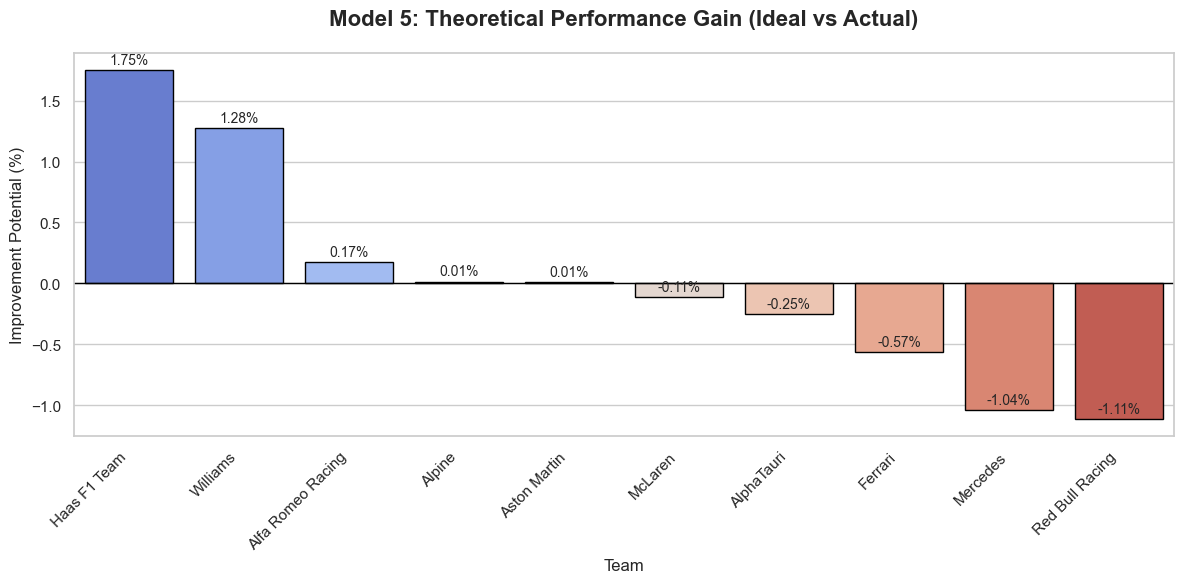

In [ ]:
# --- CELL 7: THEORETICAL PERFORMANCE (FIXED) ---
def viz_ideal_lap(df):
    print("Running Model 5: Theoretical Performance Analysis...")
    
    # 1. Predict Sector Times separately
    for s in ['sector1_time', 'sector2_time', 'sector3_time']:
        avg_s = df.groupby('race_id')[s].transform('mean')
        df[f'{s}_ratio'] = df[s] / avg_s

    features = ['tyre_age', 'compound', 'team']
    targets = ['sector1_time_ratio', 'sector2_time_ratio', 'sector3_time_ratio']
    
    data = df.dropna(subset=targets).copy()
    
    # Store encoders to retrieve names later
    le_dict = {}
    for col in features:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col]) 
        le_dict[col] = le  # Save the encoder!
        
    # 2. Train Model
    model = Ridge(alpha=1.0)
    model.fit(data[features], data[targets])
    preds = model.predict(data[features])
    
    # 3. Calculate Scores
    data['pred_total_ratio'] = preds.sum(axis=1) / 3.0
    
    # Group by 'team' (currently integers)
    team_perf = data.groupby('team')[['pace_ratio', 'pred_total_ratio']].mean().reset_index()
    
    # *** THE FIX: Convert Integers back to Team Names ***
    team_perf['team_name'] = le_dict['team'].inverse_transform(team_perf['team'])
    
    # Calculate Gain
    team_perf['potential_gain'] = (team_perf['pace_ratio'] - team_perf['pred_total_ratio']) * 100
    
    # 4. Viz
    plt.figure(figsize=(12, 6))
    df_sorted = team_perf.sort_values('potential_gain', ascending=False)
    
    sns.barplot(data=df_sorted, x='team_name', y='potential_gain', 
                palette='coolwarm', edgecolor='black')
    
    plt.title("Model 5: Theoretical Performance Gain (Ideal vs Actual)", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("Improvement Potential (%)", fontsize=12)
    plt.xlabel("Team", fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate names for readability
    plt.axhline(0, color='black', linewidth=1)
    
    # Add percentage labels
    for i, row in enumerate(df_sorted.itertuples()):
        plt.text(i, row.potential_gain + 0.05, f"{row.potential_gain:.2f}%", ha='center', fontsize=10)
        
    plt.tight_layout()
    plt.show()

viz_ideal_lap(df_clean)